In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib
from datetime import datetime
from sklearn.neural_network import MLPClassifier
import os
from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier


In [2]:
df = pd.read_csv('../data/batter_prediction_dataset/batter_prediction_dataset_V4.csv', low_memory=False)
print("Finished Loading Data")
# df = df[~df['bb_type'].isin([15, 16])]
cols_to_convert = [
    "pitch_type", "release_speed", "release_pos_x", "release_pos_y", "release_pos_z",
    "pfx_x", "pfx_z", "vx0", "vy0", "vz0", "ax", "ay", "az", "effective_speed",
    "release_spin_rate", "release_extension", "plate_x", "plate_z", "p_throws",
    "balls", "strikes", "on_3b", "on_2b", "on_1b", "outs_when_up", "inning",
    "inning_topbot", "home_score", "away_score", "at_bat_number", "pitch_number",
    "game_pk", "delta_run_exp", "zone_level", "hc_x_level", "hc_y_level",
    "hit_distance_sc_level", "estimated_ba_using_speedangle_level",
    "babip_value_level", "iso_value_level", "bat_speed_level", "swing_length_level",
    "stand", "P_bb_type_fly_ball", "P_bb_type_ground_ball", "P_bb_type_line_drive",
    "P_bb_type_popup", "P_bb_type_other", "P_launch_speed_angle_0",
    "P_launch_speed_angle_1", "P_launch_speed_angle_2", "P_launch_speed_angle_3",
    "P_launch_speed_angle_4", "P_launch_speed_angle_5", "P_launch_speed_angle_6",
    "bb_type", "batter", "prev_pitch_type_1", "prev_delta_run_exp_1",
    "prev_pitch_type_2", "prev_delta_run_exp_2", "prev_pitch_type_3",
    "prev_delta_run_exp_3", "prev_pitch_type_4", "prev_delta_run_exp_4",
    "prev_pitch_type_5", "prev_delta_run_exp_5", "prev_batter_type_1",
    "prev_batter_type_2", "prev_batter_type_3", "prev_batter_type_4",
    "prev_batter_type_5"
]

Finished Loading Data


In [3]:
for col in cols_to_convert:
    if df[col].map(type).eq(str).any():
        df[col] = df[col].str.extract('([0-9.-]+)', expand=False)
        df[col] = df[col].astype(float)
df['prev_delta_run_exp_1'] = df['prev_delta_run_exp_1'].fillna(0)
df['prev_delta_run_exp_2'] = df['prev_delta_run_exp_2'].fillna(0)
df['prev_delta_run_exp_3'] = df['prev_delta_run_exp_3'].fillna(0)
df['prev_delta_run_exp_4'] = df['prev_delta_run_exp_4'].fillna(0)
df['prev_delta_run_exp_5'] = df['prev_delta_run_exp_5'].fillna(0)

df = df.dropna()
df = df.drop(columns=['batter', 'game_pk', 'delta_run_exp'])


X = df.drop(columns=['bb_type'])
y = df['bb_type']

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Finished standardizing data")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print("Finished Splitting data")

Finished standardizing data
Finished Splitting data


In [5]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    # 'activation': ['relu', 'tanh', 'logistic'],
    # 'solver': ['adam', 'sgd'],
    # 'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 500, 1000],
}

pca_components_list = [30,50, None]
pca_accuracies = []
best_accuracy = 0
best_model = None
best_pca_components = 0

print("Starting PCA & GridSearchCV")

Starting PCA & GridSearchCV


In [6]:
for n_components in pca_components_list:
    print('n_components:', n_components)
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca, X_test_pca = X_train, X_test

    mlp_model = MLPClassifier(random_state=42)
    grid_search = GridSearchCV(mlp_model, param_grid, cv=2, scoring='accuracy', n_jobs=1, verbose=3)

    grid_search.fit(X_train_pca, y_train)

    y_pred = grid_search.best_estimator_.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    pca_accuracies.append((n_components, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid_search.best_estimator_
        best_pca_components = n_components

os.makedirs('../model', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"../model/best_mlp_batter_agent_prediction_model_{timestamp}.joblib"

n_components: 30
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.821 total time= 2.1min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.821 total time= 1.8min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.821 total time= 2.1min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.821 total time= 1.7min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.821 total time= 1.9min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.821 total time= 1.8min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.819 total time= 4.8min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.819 total time= 4.4min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.819 total time= 4.8min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.819 total time= 4.4min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.819

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.817 total time= 6.6min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.817 total time= 6.4min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.815 total time= 7.3min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.817 total time= 6.5min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.815 total time= 7.4min
n_components: 50
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.820 total time= 2.5min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.820 total time= 2.3min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.820 total time= 2.8min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.820 total time= 2.2min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.820 total time= 2.6min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=1000;, 

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.815 total time= 6.9min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=200;, score=0.816 total time= 5.3min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.817 total time= 7.0min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.816 total time= 5.5min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.817 total time= 7.9min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.816 total time= 5.9min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.813 total time= 5.6min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.813 total time= 6.3min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.813 total time= 5.2min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.812 total time= 9.6min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.813 total time= 5.0min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.812 total time=10.0min
n_components: None
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.819 total time= 3.9min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=200;, score=0.819 total time= 4.2min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.819 total time= 3.8min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.819 total time= 3.9min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.819 total time= 3.7min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=1000;

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.814 total time= 7.3min


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=200;, score=0.814 total time= 7.4min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.814 total time= 9.6min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.812 total time= 9.2min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.814 total time=10.0min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=1000;, score=0.812 total time= 8.6min


In [21]:
print(best_pca_components)
pca = PCA(n_components=best_pca_components)
pca.fit_transform(X_train)
joblib.dump({
    'model': best_model,
    'pca': pca if best_pca_components is not None else None,
    'n_components': best_pca_components,
    'accuracy': best_accuracy
}, model_filename)

print(f"Model saved to {model_filename}")

30
Model saved to ../model/best_mlp_batter_agent_prediction_model_20250107_182126.joblib


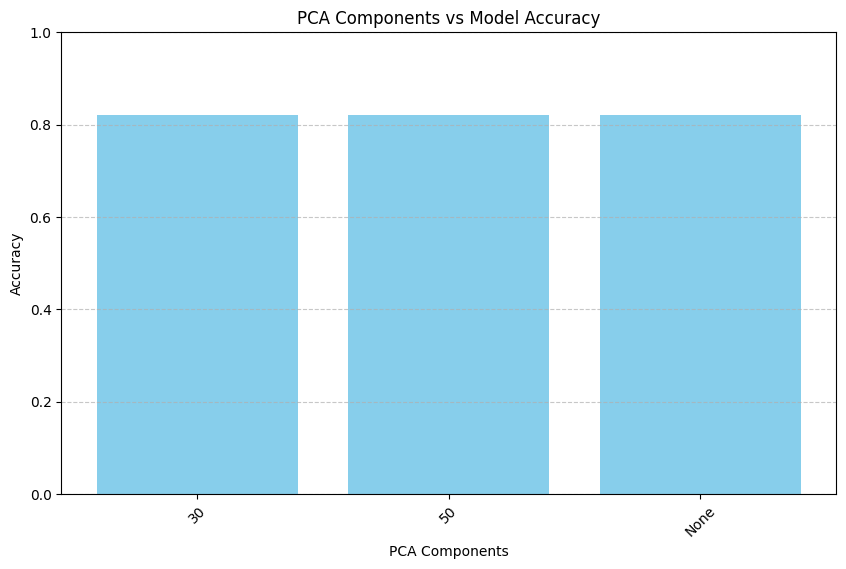

Accuracy of loaded model: 0.8176


In [22]:
components, accuracies = zip(*pca_accuracies)
components = ['None' if c is None else str(c) for c in components]

plt.figure(figsize=(10, 6))
plt.bar(components, accuracies, color='skyblue')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.title('PCA Components vs Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

model_folder = os.path.join('..', 'model')
file_path = os.path.join(model_folder, model_filename)

saved_model = joblib.load(file_path)
loaded_model = saved_model['model']
loaded_pca = saved_model['pca']

if loaded_pca is not None:
    X_test_pca = loaded_pca.transform(X_test)
else:
    X_test_pca = X_test

y_pred_loaded = loaded_model.predict(X_test_pca)
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy of loaded model: {loaded_accuracy:.4f}")

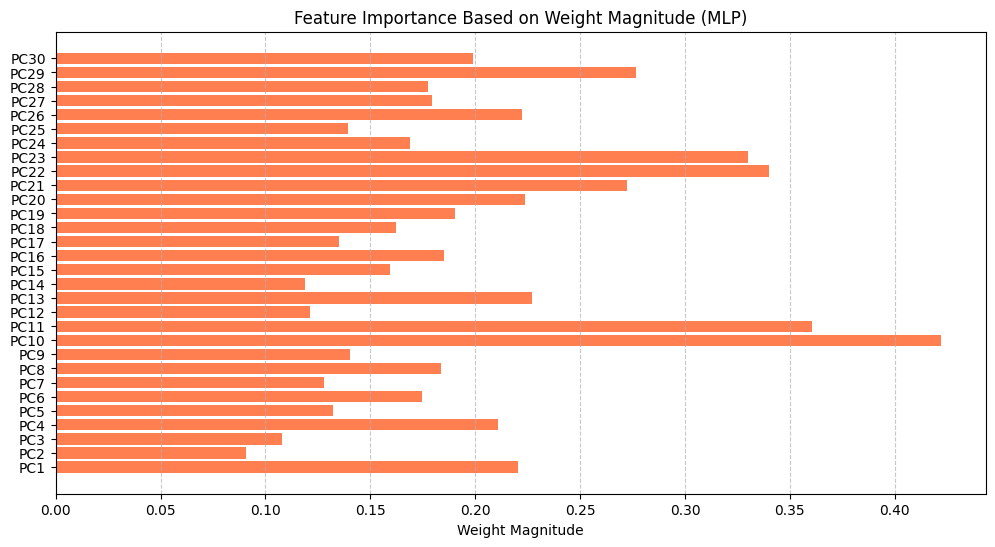

In [23]:
import numpy as np

coefs = best_model.coefs_[0]  # First layer weights
feature_importance = np.mean(np.abs(coefs), axis=1)

features = X.columns if best_pca_components is None else [f'PC{i+1}' for i in range(best_pca_components)]
plt.figure(figsize=(12, 6))
plt.barh(features, feature_importance, color='coral')
plt.xlabel('Weight Magnitude')
plt.title('Feature Importance Based on Weight Magnitude (MLP)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [24]:
param_grid = {
    'iterations': [100, 200, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    # 'l2_leaf_reg': [1, 3, 5, 7],
    # 'bagging_temperature': [0, 1, 2],
    # 'border_count': [32, 64, 128],
    # 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
}

pca_components_list = [30,50,None]
pca_accuracies = []
best_accuracy = 0
best_model = None
best_pca_components = 0

In [25]:
for n_components in pca_components_list:
    print('n_components:', n_components)
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca, X_test_pca = X_train, X_test

    cat_model = CatBoostClassifier(eval_metric='MultiClass', random_state=42, task_type='GPU', verbose=0)
    grid_search = GridSearchCV(cat_model, param_grid, cv=2, scoring='accuracy', n_jobs=1)

    grid_search.fit(X_train_pca, y_train)

    y_pred = grid_search.best_estimator_.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    pca_accuracies.append((n_components, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid_search.best_estimator_
        best_pca_components = n_components


n_components: 30
n_components: 50
n_components: None


None


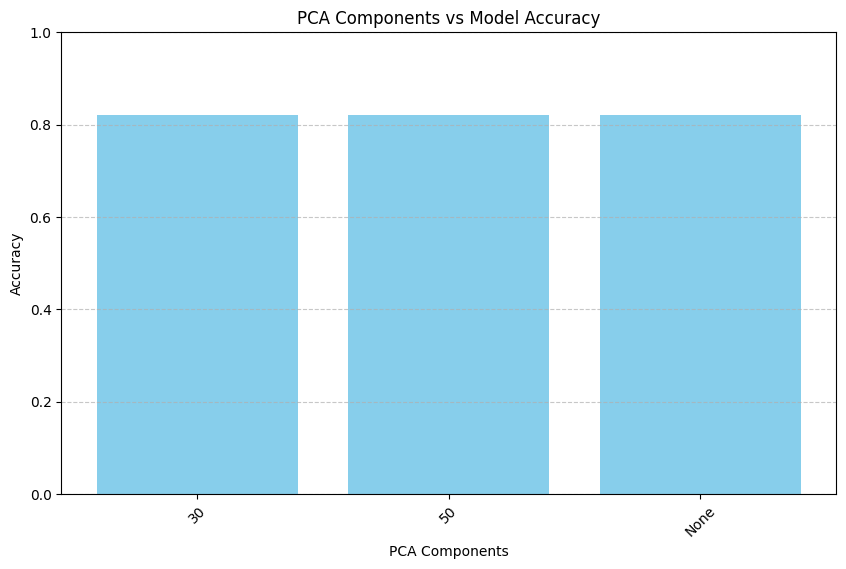

In [26]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"../model/best_catboost_batter_agent_prediction_model_{timestamp}.joblib"
model_folder = os.path.join('..', 'model')
os.makedirs(model_folder, exist_ok=True)

model_filename = f"best_catboost_batter_agent_prediction_model_{timestamp}.joblib"
file_path = os.path.join(model_folder, model_filename)

print(best_pca_components)
pca = PCA(n_components=best_pca_components)
pca.fit_transform(X_train)
joblib.dump({
    'model': best_model,
    'pca': pca if best_pca_components is not None else None,
    'n_components': best_pca_components,
    'accuracy': best_accuracy
}, file_path)



components, accuracies = zip(*pca_accuracies)
components = ['None' if c is None else str(c) for c in components]

plt.figure(figsize=(10, 6))
plt.bar(components, accuracies, color='skyblue')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.title('PCA Components vs Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


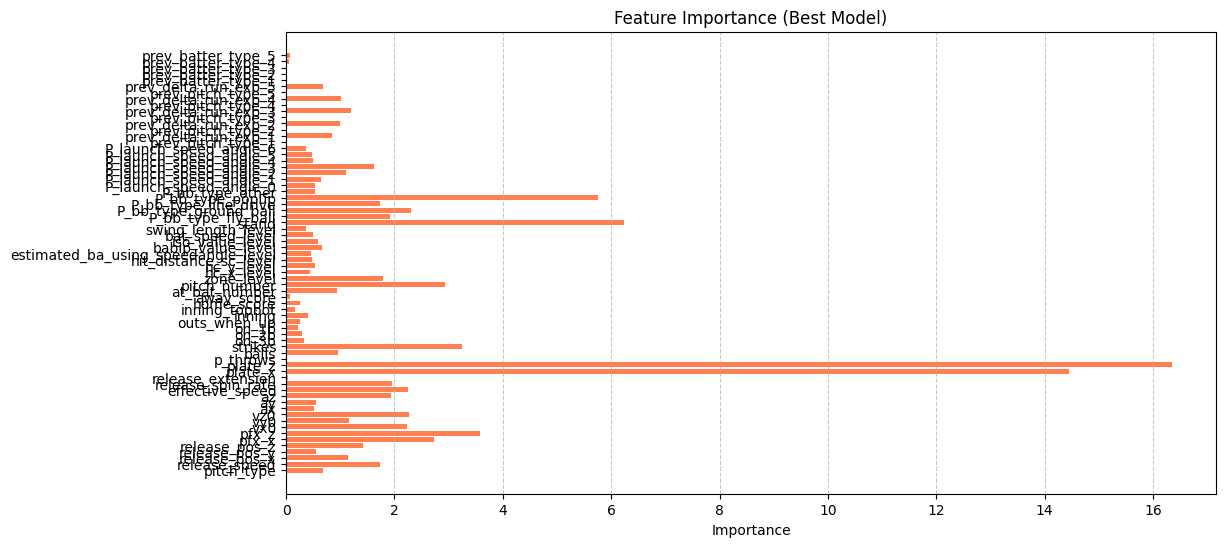

Best accuracy: 0.8214 with PCA components: None


In [27]:
feature_importances = best_model.feature_importances_

if best_pca_components is None:
    features = X.columns
else:
    features = [f'PC{i+1}' for i in range(best_pca_components)]

plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances, color='coral')
plt.xlabel('Importance')
plt.title('Feature Importance (Best Model)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


print(f"Best accuracy: {best_accuracy:.4f} with PCA components: {best_pca_components}")


In [28]:
saved_model = joblib.load(file_path)
loaded_model = saved_model['model']
loaded_pca = saved_model['pca']

if loaded_pca is not None:
    X_test_pca = loaded_pca.transform(X_test)
else:
    X_test_pca = X_test

y_pred_loaded = loaded_model.predict(X_test_pca)
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy of loaded model: {loaded_accuracy:.4f}")

Accuracy of loaded model: 0.8214
